In [223]:
from matplotlib import rcParamsDefault
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler

class CSVTrafficDataloader:
    def __init__(self, file_path):
        self.file_path = file_path
        self.data = None
    
    def load_data(self):
        try:
            self.data = pd.read_csv(self.file_path)[["Year", "Month", "Flt"]]
            self._preprocess_data()

        except Exception as e:
            print(f"Error loading data from file {self.file_path}: {e}")
            return None

    def _preprocess_data(self):
        if self.data is not None:
            self.data["Flt"] = self._turn_col_to_int(self.data["Flt"])
        else:
            print("Data is not loaded. Call load_data first")

    def _turn_col_to_int(self, arr):
        return arr.str.replace(",","").astype(int)

class DataProcessor:
    def __init__(self, data, k_lags, normalize_method="minmax") -> None:
        self.data = data
        self.k_lags = k_lags
        self.normalize_method = normalize_method
        self.train_data = None
        self.test_data = None
        self.val_data = None
    
    def create_lag_features(self, target_column='Flt'):
        for i in range(1, self.k_lags + 1):
            self.data[f'lag_{i}'] = self.data[target_column].shift(i)
        self.data.dropna(inplace=True)  # Dropping rows with NaN values resulting from the shift operation

    def normalize(self):
        if self.normalize_method == "minmax":
            scaler = MinMaxScaler()

        elif self.normalize_method == "zscore":
            scaler = StandardScaler()

        else:
            raise ValueError("Unsupported normalization method")
        
        full_train_data = pd.concat([self.train_data, self.val_data])
        scaler.fit(full_train_data[self.train_data.columns])
        self.train_data[self.train_data.columns] = scaler.transform(self.train_data[self.train_data.columns])
        self.val_data[self.val_data.columns] = scaler.transform(self.val_data[self.val_data.columns])
        self.test_data[self.test_data.columns] = scaler.transform(self.test_data[self.test_data.columns])
        

    def split_data(self, train_start=2003, val_start=2016, test_start=2020):
        self._set_month_year_index()

        if self.data is not None:
            # Splitting the data
            self.train_data = self.data[(self.data['Year'] >= train_start) & (self.data['Year'] < val_start)].drop(["Year", "Month"], axis=1)
            self.val_data = self.data[(self.data['Year'] >= val_start) & (self.data["Year"] < test_start)].drop(["Year", "Month"], axis=1)
            self.test_data = self.data[(self.data['Year'] >= test_start)].drop(["Year", "Month"], axis=1)

        else:
            print("Data not loaded. Call load_data first")
            return None, None
        
    def _set_month_year_index(self):
        """
        Sets the DataFrame index as a combination of month and year.
        """
        # Assuming 'Month' and 'Year' are columns in the DataFrame
        self.data['Month_Year'] = pd.to_datetime(self.data[['Year', 'Month']].assign(DAY=1))
        self.data.set_index('Month_Year', inplace=True)

class PerformanceEvaluator:
    def __init__(self, y_pred, y):
        if not isinstance(y, pd.Series) or not isinstance(y_pred, pd.Series):
            raise ValueError("y and y_pred must be pandas Series with a DateTimeIndex.")
        self.y_pred = y_pred
        self.y = y
        self.y_pred_df = pd.DataFrame({
            "Actual": self.y,
            "Predictions": self.y_pred
        })

    def _filter_by_time_window(self, start_year="2020", end_year="2023"):
        start_date = pd.to_datetime(f"{start_year}-01-01")
        end_date = pd.to_datetime(f"{end_year}-12-31")
        return self.y_pred_df.loc[start_date:end_date]

    def calculate_rmse(self, start_year="2020", end_year="2023"):
        filtered_df = self._filter_by_time_window(start_year, end_year)
        error = filtered_df['Predictions'] - filtered_df['Actual']
        mse = np.mean(error**2)
        rmse = np.sqrt(mse)
        rmse = rmse*(964102 - 632620)
        return rmse

    def calculate_mape(self, start_year="2020", end_year="2023"):
        filtered_df = self._filter_by_time_window(start_year, end_year)
        error = filtered_df['Predictions'] - filtered_df['Actual']
        pct_error = np.abs(error / filtered_df['Actual']) * 100
        mape = np.mean(pct_error)
        mape = mape*(964102 - 632620)
        return mape

    def plot_test_samples_with_predictions(self, start_year="2020", end_year="2023"):
        filtered_df = self._filter_by_time_window(start_year, end_year)
        
        plt.figure(figsize=(10, 6))
        plt.plot(filtered_df['Actual'], label='Actual', marker='o')
        plt.plot(filtered_df['Predictions'], label='Predictions', linestyle='--', marker='x')
        # plt.title('Actual vs Predicted Values')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True) 
        plt.show()


### ITEM A
Exiba o gr´afico da s´erie temporal completa. Numa inspe¸c˜ao visual simples, ´e poss´ıvel reconhecer ao menos
trˆes faixas distintas de comportamento aproximadamente “regular” na s´erie: (i) Jan/2003 a Ago/2008; (ii)
Set/2008 a Dez/2019; (ii) Jan/2020 a Set/2023. Discuta poss´ıveis raz˜oes hist´oricas / econˆomicas para essas
transi¸c˜oes de comportamento.

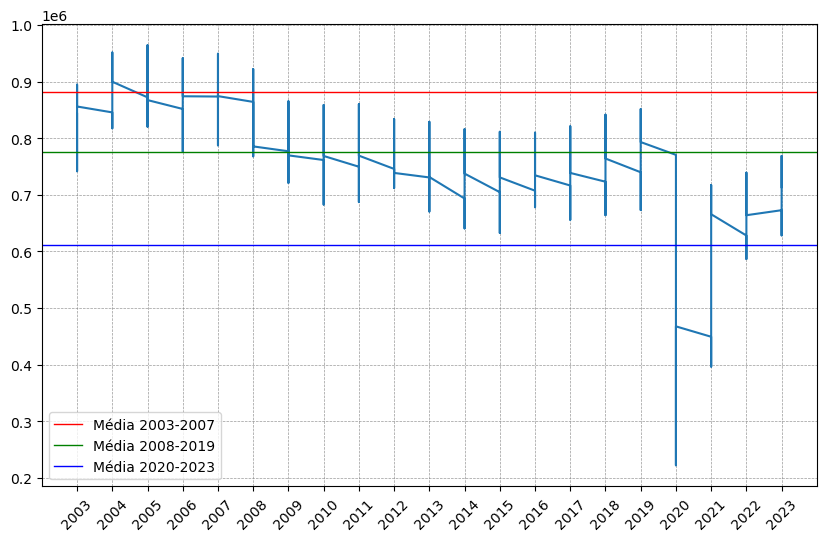

In [211]:
from sympy import rotations

loader = CSVTrafficDataloader("/workspace/unicamp/IA048/Exercise_Linear_Regression/data/air traffic.csv")
loader.load_data()
data = loader.data

mean1 = data.query("Year<2008")["Flt"].mean()
mean2 = data.query("Year>=2008 and Year<2020")["Flt"].mean()
mean3 = data.query("Year>=2020")["Flt"].mean()

plt.figure(figsize=(10, 6))  
plt.xticks(range(data['Year'].min(), data['Year'].max() + 1), rotation=45)
plt.plot(data['Year'], data['Flt'])
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.8)
plt.axhline(y=mean1, color='r', linestyle='-', linewidth=1, label='Média 2003-2007')  # Red line for mean1
plt.axhline(y=mean2, color='g', linestyle='-', linewidth=1, label='Média 2008-2019')  # Green line for mean2
plt.axhline(y=mean3, color='b', linestyle='-', linewidth=1, label='Média 2020-2023')  # Blue line for mean3
plt.legend()


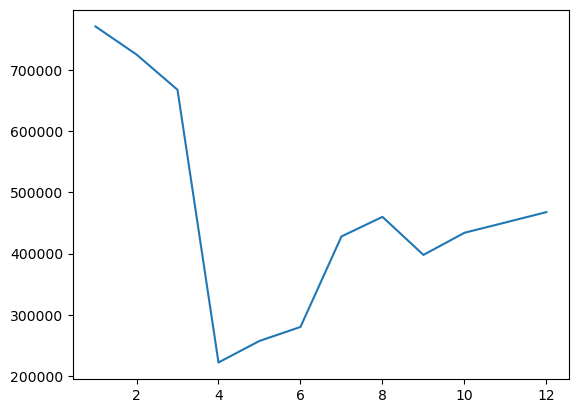

In [212]:
plt.plot(data.query("Year == 2020")["Month"], data.query("Year == 2020")["Flt"])

In [213]:
964102 - 632620

331482

### Item B
Divida a s´erie em dois conjuntos: (i) treinamento e valida¸c˜ao, com amostras de 2003 a 2019; (ii) teste, com
amostras de 2020 a 2023. Fa¸ca a an´alise de desempenho do preditor linear ´otimo, no sentido de quadrados
m´ınimos irrestrito, considerando:

A progress˜ao do valor da raiz quadrada do erro quadr´atico m´edio (RMSE, do inglˆes root mean squared
error ), junto aos dados de valida¸c˜ao, em fun¸c˜ao do n´umero de entradas (K) do preditor (desde K = 1
a K = 24). Apresente o gr´afico obtido e busque tecer conjecturas sobre os motivos subjacentes a seu
comportamento.

MIN RMSE: 12224.30440933466
K: 13


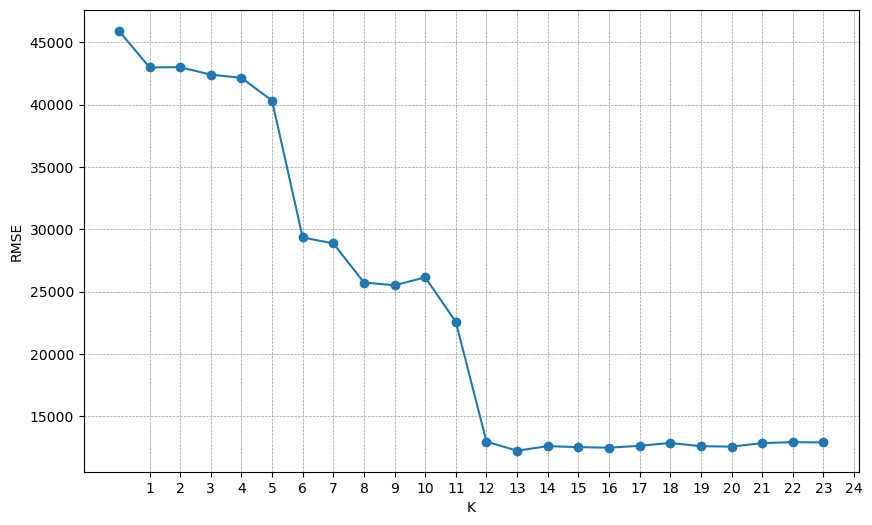

In [215]:
def run_model(k):
    loader = CSVTrafficDataloader("/workspace/unicamp/IA048/Exercise_Linear_Regression/data/air traffic.csv")
    loader.load_data()
    processor = DataProcessor(loader.data, k_lags=k)
    processor.create_lag_features()
    processor.split_data()
    processor.normalize()
    X_train, y_train, X_val, y_val, X_test, y_test = processor.train_data.drop("Flt", axis=1), processor.train_data["Flt"], processor.val_data.drop("Flt", axis=1), processor.val_data["Flt"], processor.test_data.drop("Flt", axis=1), processor.test_data["Flt"]
    linear_regressor = LinearRegression()
    linear_regressor.fit(X_train, y_train)
    y_pred = linear_regressor.predict(X_val)
    y_pred = pd.Series(y_pred, index=y_val.index)
    evaluator = PerformanceEvaluator(y_pred, y_val)

    return evaluator

def evaluate_for_k(init_val, final_val):
    results = []
    for k in range(init_val, final_val+1):
        evaluator = run_model(k)
        rmse = evaluator.calculate_rmse(start_year=2016, end_year=2019)
        aux = {"k":k,
               "rmse": rmse}
        results.append(aux)

    return results

results = evaluate_for_k(1, 24)
results_df = pd.DataFrame(results, columns=["k", "rmse"])
plt.figure(figsize=(10,6))
plt.plot(results_df["rmse"], marker="o")
plt.xticks(results_df["k"])
plt.ylabel("RMSE")
plt.xlabel("K")
# plt.title("Impact of lag feature in model performance")
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.8)

print(f"MIN RMSE: {results_df.loc[results_df['rmse'].idxmin(), 'rmse']}\nK: {results_df['rmse'].idxmin()}")

In [155]:
loader = CSVTrafficDataloader("/workspace/unicamp/IA048/Exercise_Linear_Regression/data/air traffic.csv")
loader.load_data()
processor = DataProcessor(loader.data, k_lags=1, normalize_method="zscore")
processor.create_lag_features()
processor.split_data()
processor.normalize()
X_train, y_train, X_val, y_val, X_test, y_test = processor.train_data.drop("Flt", axis=1), processor.train_data["Flt"], processor.val_data.drop("Flt", axis=1), processor.val_data["Flt"], processor.test_data.drop("Flt", axis=1), processor.test_data["Flt"]
print(len(X_train)/(len(X_train) + len(X_val) + len(X_test)))

0.625


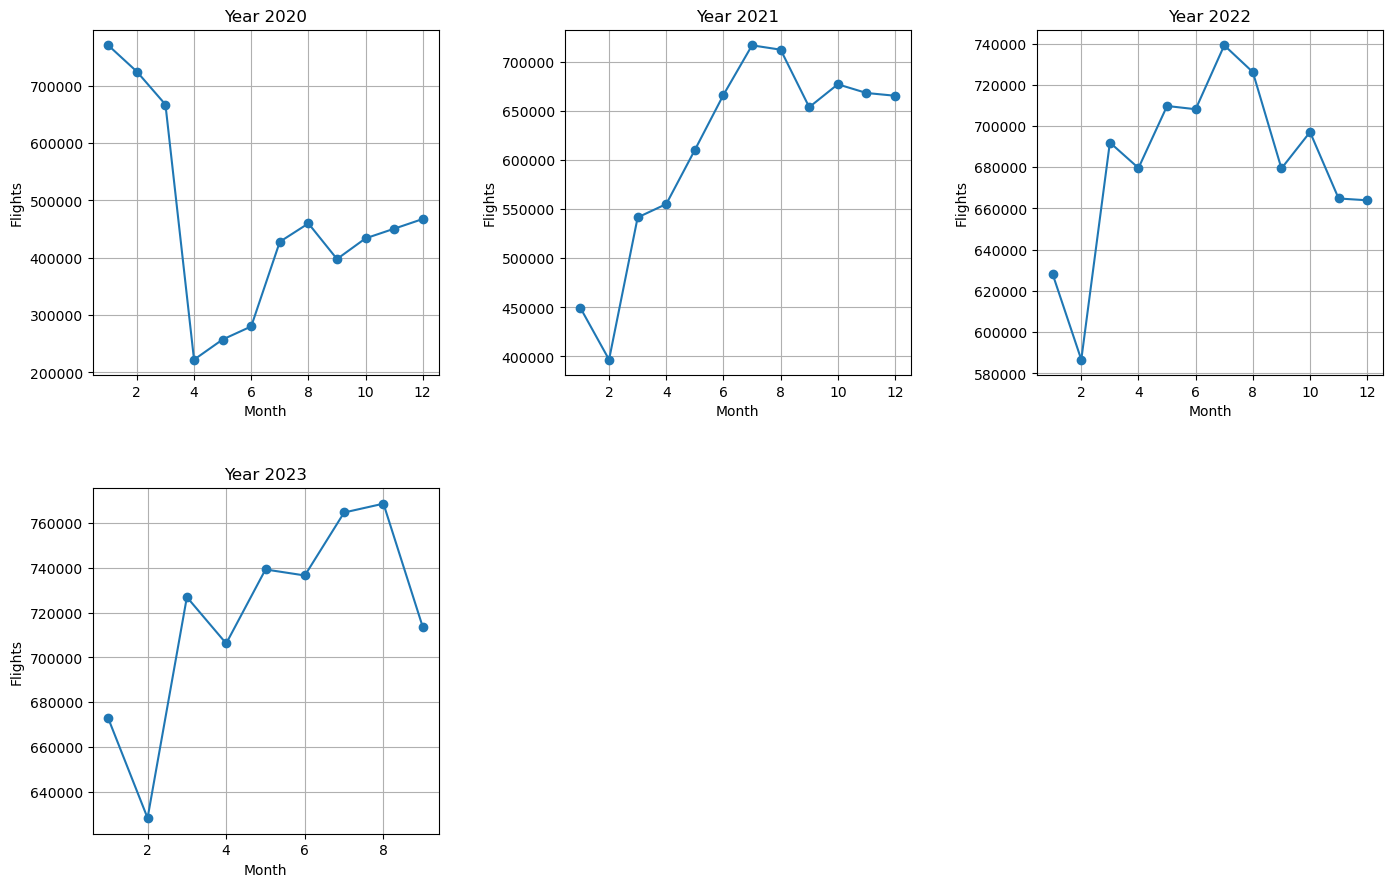

In [221]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'df' is your DataFrame and it contains 'year', 'month', and 'flt' columns
# Example of creating a DataFrame
# df = pd.DataFrame({
#     'year': [2000, 2000, 2000, 2001, 2001, 2001],
#     'month': [1, 2, 3, 1, 2, 3],
#     'flt': [100, 150, 130, 120, 170, 160]
# })
loader = CSVTrafficDataloader("/workspace/unicamp/IA048/Exercise_Linear_Regression/data/air traffic.csv")
loader.load_data()
data = loader.data
data = data.loc[data["Year"]>= 2020]
# Group the DataFrame by year
grouped = data.groupby('Year')

# Determine the number of subplot rows and columns
n_years = len(grouped)
cols = 3  # for example, adjust as needed
rows = n_years // cols + (n_years % cols > 0)

# Create a figure and a grid of subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
fig.tight_layout(pad=6.0)

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Loop over each group and create a plot for each year
for i, (year, data) in enumerate(grouped):
    ax = axes[i]
    ax.plot(data['Month'], data['Flt'], marker='o', linestyle='-')
    ax.set_title(f'Year {year}')
    ax.set_xlabel('Month')
    ax.set_ylabel('Flights')
    ax.grid(True)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.show()


0.7635467980295566
0.7623762376237624
0.7611940298507462
0.76
0.7587939698492462
0.7575757575757576
0.7563451776649747
0.7551020408163265
0.7538461538461538
0.7525773195876289
0.7512953367875648
0.75
0.7486910994764397
0.7473684210526316
0.746031746031746
0.7446808510638298
0.7433155080213903
0.7419354838709677
0.7405405405405405
0.7391304347826086
0.7377049180327869
0.7362637362637363
0.7348066298342542
0.7333333333333333
MIN RMSE: 0.17282657139370097
K: 13


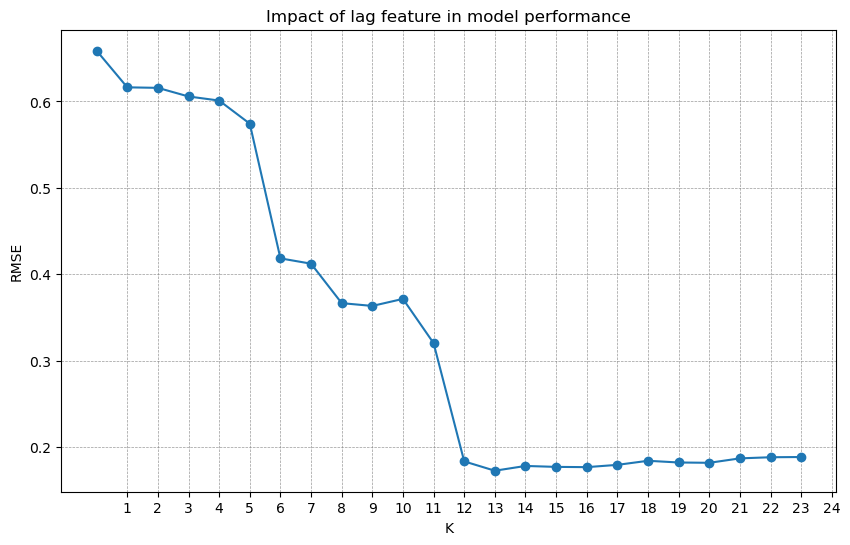

In [145]:
def run_model(k):
    loader = CSVTrafficDataloader("/workspace/unicamp/IA048/Exercise_Linear_Regression/data/air traffic.csv")
    loader.load_data()
    processor = DataProcessor(loader.data, k_lags=k, normalize_method="zscore")
    processor.create_lag_features()
    processor.split_data()
    processor.normalize()
    X_train, y_train, X_val, y_val, X_test, y_test = processor.train_data.drop("Flt", axis=1), processor.train_data["Flt"], processor.val_data.drop("Flt", axis=1), processor.val_data["Flt"], processor.test_data.drop("Flt", axis=1), processor.test_data["Flt"]
    print(len(X_train)/(len(X_train) + len(X_val)))
    linear_regressor = LinearRegression()
    linear_regressor.fit(X_train, y_train)
    y_pred = linear_regressor.predict(X_val)
    y_pred = pd.Series(y_pred, index=y_val.index)
    evaluator = PerformanceEvaluator(y_pred, y_val)

    return evaluator

def evaluate_for_k(init_val, final_val):
    results = []
    for k in range(init_val, final_val+1):
        evaluator = run_model(k)
        rmse = evaluator.calculate_rmse(start_year=2016, end_year=2019)
        aux = {"k":k,
               "rmse": rmse}
        results.append(aux)

    return results

results = evaluate_for_k(1, 24)
results_df = pd.DataFrame(results, columns=["k", "rmse"])
plt.figure(figsize=(10,6))
plt.plot(results_df["rmse"], marker="o")
plt.xticks(results_df["k"])
plt.ylabel("RMSE")
plt.xlabel("K")
plt.title("Impact of lag feature in model performance")
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.8)

print(f"MIN RMSE: {results_df.loc[results_df['rmse'].idxmin(), 'rmse']}\nK: {results_df['rmse'].idxmin()}")

### Item B2

O gr´afico com as amostras de teste da s´erie temporal e as respectivas estimativas geradas pela melhor
vers˜ao do preditor (i.e., usando o valor de K que levou ao m´ınimo erro de valida¸c˜ao). Obtenha, tamb´em,
o RMSE e o erro percentual absoluto m´edio (MAPE, do inglˆes mean absolute percentage error ) para o
conjunto de teste

{'fit_intercept': True, 'copy_X': True, 'n_jobs': None, 'positive': False, 'feature_names_in_': array(['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7',
       'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12', 'lag_13'],
      dtype=object), 'n_features_in_': 13, 'coef_': array([ 0.81198951,  0.0679084 ,  0.06818949, -0.0282376 , -0.02413623,
       -0.13442767,  0.06181808,  0.04601972,  0.07094574, -0.0313255 ,
       -0.01915924,  0.83244741, -0.74598925]), 'rank_': 13, 'singular_': array([8.45588942, 3.6358762 , 3.49856163, 2.08883247, 1.94222355,
       1.60805359, 1.56400593, 0.98715064, 0.91647965, 0.84419331,
       0.63985547, 0.53738828, 0.50226217]), 'intercept_': 0.011499798785722937}


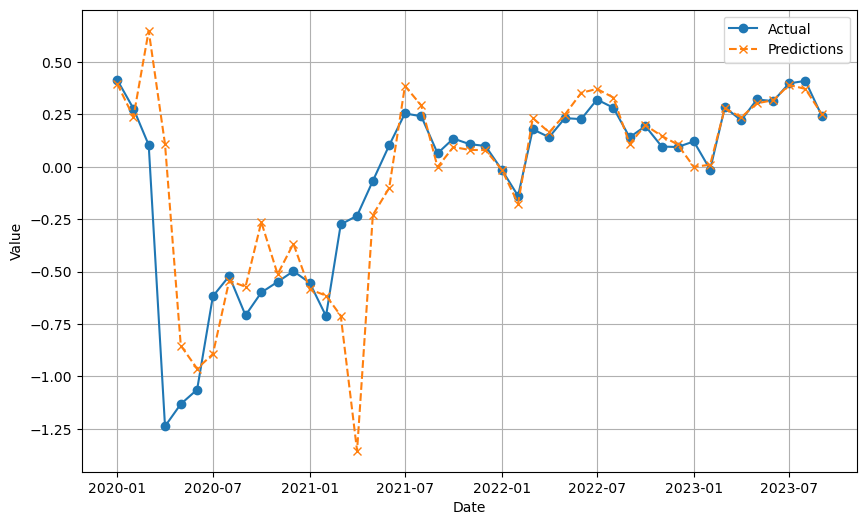

RMSE: 99134.10879357533
MAPE: 20325121.688008703


In [228]:
loader = CSVTrafficDataloader("/workspace/unicamp/IA048/Exercise_Linear_Regression/data/air traffic.csv")
loader.load_data()
processor = DataProcessor(loader.data, k_lags=13)
processor.create_lag_features()
processor.split_data()
processor.normalize()
X_train, y_train, X_val, y_val, X_test, y_test = processor.train_data.drop("Flt", axis=1), processor.train_data["Flt"], processor.val_data.drop("Flt", axis=1), processor.val_data["Flt"], processor.test_data.drop("Flt", axis=1), processor.test_data["Flt"]
linear_regressor = LinearRegression()
X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])
linear_regressor.fit(X_train_val, y_train_val)
print(linear_regressor.__dict__)
y_pred = linear_regressor.predict(X_test)
y_pred = pd.Series(y_pred, index=y_test.index)
evaluator = PerformanceEvaluator(y_pred, y_test)
rmse = evaluator.calculate_rmse(start_year=2020, end_year=2023)
mape = evaluator.calculate_mape(start_year=2020, end_year=2023)
evaluator.plot_test_samples_with_predictions(start_year=2020, end_year=2023)
print(f"RMSE: {rmse}\nMAPE: {mape}")


### B3

 O gr´afico com as amostras apenas dos dois ´ultimos anos (2022 e 2023) e as estimativas geradas pelo
melhor preditor, al´em dos respectivos valores de RMSE e MAPE.


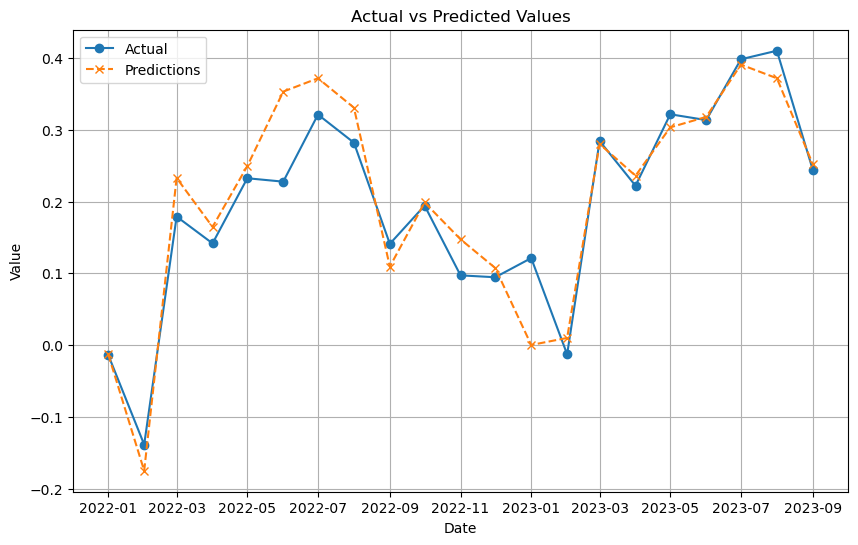

RMSE: 0.04720614559829888
MAPE: 27.10699304477267


In [120]:
evaluator.plot_test_samples_with_predictions(start_year=2022, end_year=2023)
rmse = evaluator.calculate_rmse(start_year=2022, end_year=2023)
mape = evaluator.calculate_mape(start_year=2022, end_year=2023)
print(f"RMSE: {rmse}\nMAPE: {mape}")

### Item C

Repita o procedimento detalhado nos itens b1) e b2), mas adotando a seguinte divis˜ao dos dados: (i)
treinamento – amostras de 2003 a 2019; (ii) valida¸c˜ao – amostras de 2020 e 2021; (iii) teste, com amostras
de 2022 e 2023. Discuta os resultados obtidos e fa¸ca uma compara¸c˜ao com o cen´ario anterior (especialmente
com o que foi obtido no item b3).


MIN RMSE: 54234.71360355904
K: 4


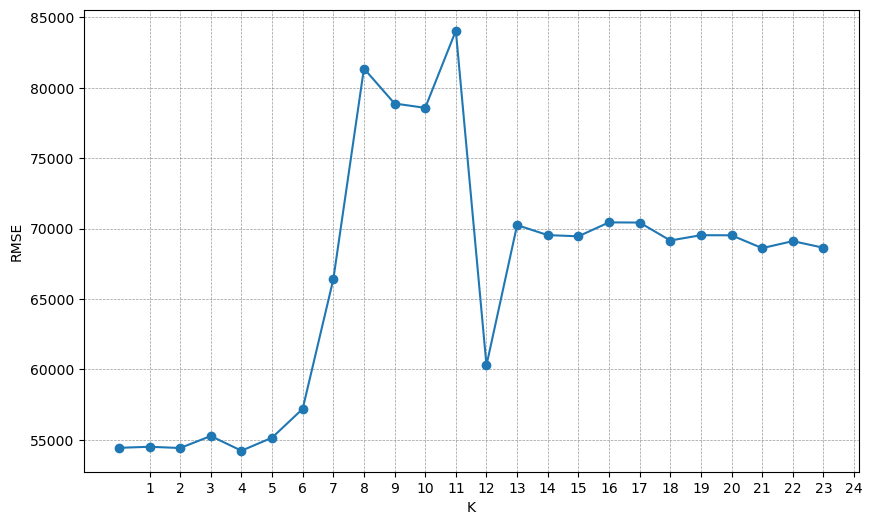

In [229]:
def run_model_(k):
    loader = CSVTrafficDataloader("/workspace/unicamp/IA048/Exercise_Linear_Regression/data/air traffic.csv")
    loader.load_data()
    processor = DataProcessor(loader.data, k_lags=k)
    processor.create_lag_features()
    processor.split_data(train_start=2003, val_start=2020, test_start=2022)
    processor.normalize()
    X_train, y_train, X_val, y_val, X_test, y_test = processor.train_data.drop("Flt", axis=1), processor.train_data["Flt"], processor.val_data.drop("Flt", axis=1), processor.val_data["Flt"], processor.test_data.drop("Flt", axis=1), processor.test_data["Flt"]
    linear_regressor = LinearRegression()
    linear_regressor.fit(X_train, y_train)
    y_pred = linear_regressor.predict(X_val)
    y_pred = pd.Series(y_pred, index=y_val.index)
    evaluator = PerformanceEvaluator(y_pred, y_val)

    return evaluator

def evaluate_for_k_(init_val, final_val):
    results = []
    for k in range(init_val, final_val+1):
        evaluator = run_model_(k)
        rmse = evaluator.calculate_rmse(start_year=2020, end_year=2021)
        aux = {"k":k,
               "rmse": rmse}
        results.append(aux)

    return results

results = evaluate_for_k_(1, 24)
results_df = pd.DataFrame(results, columns=["k", "rmse"])
plt.figure(figsize=(10,6))
plt.plot(results_df["rmse"], marker="o")
plt.xticks(results_df["k"])
plt.ylabel("RMSE")
plt.xlabel("K")
# plt.title("Impact of lag feature in model performance")
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.8)

print(f"MIN RMSE: {results_df.loc[results_df['rmse'].idxmin(), 'rmse']}\nK: {results_df['rmse'].idxmin()}")

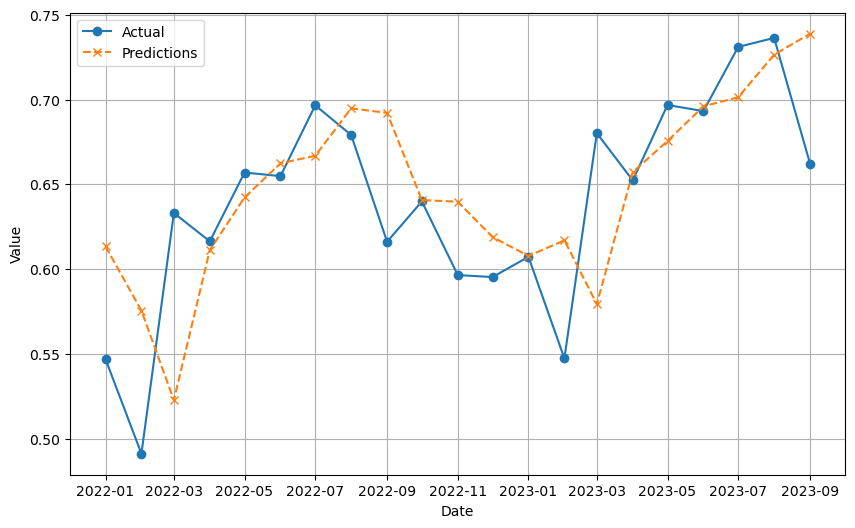

RMSE: 17077.416032123245
MAPE: 2053630.9123883354


In [234]:
loader = CSVTrafficDataloader("/workspace/unicamp/IA048/Exercise_Linear_Regression/data/air traffic.csv")
loader.load_data()
processor = DataProcessor(loader.data, k_lags=4)
processor.create_lag_features()
processor.split_data(train_start=2003, val_start=2020, test_start=2022)
processor.normalize()
X_train, y_train, X_val, y_val, X_test, y_test = processor.train_data.drop("Flt", axis=1), processor.train_data["Flt"], processor.val_data.drop("Flt", axis=1), processor.val_data["Flt"], processor.test_data.drop("Flt", axis=1), processor.test_data["Flt"]
linear_regressor = LinearRegression()
X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])
linear_regressor.fit(X_train_val, y_train_val)
y_pred = linear_regressor.predict(X_test)
y_pred = pd.Series(y_pred, index=y_test.index)
evaluator = PerformanceEvaluator(y_pred, y_test)
rmse = evaluator.calculate_rmse(start_year=2022, end_year=2023)
mape = evaluator.calculate_mape(start_year=2022, end_year=2023)
evaluator.plot_test_samples_with_predictions(start_year=2022, end_year=2023)
print(f"RMSE: {rmse}\nMAPE: {mape}")
